# <center> Advanced Machine Learning - Assignment 3
## <center> Soham Pyne (MDS202148) <br><br>

### Importing necessary libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
import imageio
import os

In [2]:
def save_frames_as_gif(frames, path='/Users/Soham/Documents/CMI-SEM 3/Advanced ML', filename='gym_animation.gif'):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=15)

#### Creating a cartpole agent class which has attributes for Q-learning and SARSA

In [3]:
class CartPole_agent():
    def __init__(self,n_episodes = 500, gamma = 0.9, lr = 0.15, epsilon = 0.2, bin_size = 20, state_space = 4, action_space = 2):
        """
        Defining the hyperparameters of the problem
        
        "gamma" denotes the discount factor applicable to the rewards of future state action pairs
        "lr" denotes the learning rates of the training
        "epsilon" denotes 
        """
        self.state_space = state_space
        self.action_space = action_space
        self.n_epsiodes = n_episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.bin_size = bin_size
        """
        Defining the environment using the OpenAI gym 
        """
        
        self.env = gym.make("CartPole-v1", render_mode='rgb_array')
        
        """
        Defining the states and bins to discretize the states
        """
        self.state_bins = [np.linspace(-2.4,2.4,bin_size),np.linspace(-10,10,bin_size),np.linspace(-0.418,0.418,bin_size),np.linspace(-10,10,bin_size)]
        self.q_table = np.random.uniform(low=-0.05,high=0.05,size=([bin_size] * state_space + [action_space]))
        self.q_v2_table = np.random.uniform(low=-0.05,high=0.05,size=([bin_size] * state_space + [action_space]))
        self.sarsa_table = np.random.uniform(low=-0.05,high=0.05,size=([bin_size] * state_space + [action_space]))
        
    def Discrete(self,state, bins):
        index = []
        for i in range(len(state)): 
            index.append(np.digitize(state[i],bins[i]))     #(np.searchsorted(bins[i], state[i], side='left'))
        return tuple(index)
        
    def epsilon_greedy(self,current_state,table):
        if np.random.uniform(0,1) < self.epsilon:                                                #epsilon greedy strategy
            action = self.env.action_space.sample()
        else:
            action = np.argmax(table[current_state])
        return action
    
    def updateQ(self,current_state, next_state, action, reward,table):
        max_future_q = np.max(table[next_state])
        current_q = table[current_state+(action,)]
        new_q = (1-self.lr)*current_q + self.lr*(reward + self.gamma*max_future_q) # Q value update
        return new_q
    
    def updateSarsa(self,current_state, next_state, action, next_action, reward):
        future_sarsa = self.sarsa_table[next_state+(next_action,)]
        current_sarsa = self.sarsa_table[current_state+(action,)]
        new_sarsa = (1-self.lr)*current_sarsa + self.lr*(reward + self.gamma*future_sarsa) #Sarsa update
        return new_sarsa
        
            
    def Qtrain(self,episodes):
        reward_list = []
            
        for episode in range(1,episodes+1):
            steps = 0
            current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
            score_per_episode = 0
            temp_start = time.time()
                
            while True:
                steps += 1
                ep_start = time.time()                  
                # self.env.render()
                    
                action = self.epsilon_greedy(current_state,self.q_table)
                    
                observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated or (steps > 500)
                    
                next_state = self.Discrete(observation,self.state_bins)
                    
                score_per_episode += reward
                    
                if not done:
                    self.q_table[current_state+(action,)] = self.updateQ(current_state, next_state, action, reward, self.q_table)

                    current_state = next_state
                        
                else:
                    score_per_episode += reward
                    reward_list.append(score_per_episode)
                    if episode% 1000 == 0: 
                        print('Episode {} stopped in step : {} with total reward : {} in time {}'.format(episode,steps,score_per_episode,(time.time()-ep_start)))
                    break
        plt.scatter([i for i in range(1,episodes+1)],reward_list)           
        self.env.close()
        
        
    def Q_version_two(self,episodes):
        reward_list = []
            
        for episode in range(1,episodes+1):
            steps = 0
            current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
            score_per_episode = 0
            temp_start = time.time()
                
            while True:
                steps += 1
                ep_start = time.time()                  
                # self.env.render()
                    
                action = self.epsilon_greedy(current_state,self.q_v2_table)
                    
                observation, reward, terminated, truncated, info = self.env.step(action)
                
                ##
                done = terminated or truncated or (steps > 500)

                """Addition of extra conditions for termination"""
                
                pos_reward_condition = (observation[2] > -0.209 and observation[2] < -0.104) or (observation[2]< 0.209 and observation[2] > 0.104)
            
                if pos_reward_condition:
                    reward = 2
                else:
                    reward = 0
                ##    
                next_state = self.Discrete(observation,self.state_bins)
                    
                score_per_episode += reward
                    
                if not done:
                    self.q_v2_table[current_state+(action,)] = self.updateQ(current_state, next_state, action, reward, self.q_v2_table)

                    current_state = next_state
                        
                else:
                    score_per_episode += reward
                    reward_list.append(score_per_episode)
                    if episode% 1000 == 0: 
                        print('Episode {} stopped in step : {} with total reward : {} in time {}'.format(episode,steps,score_per_episode,(time.time()-ep_start)))
                    break
        plt.scatter([i for i in range(1,episodes+1)],reward_list)           
        self.env.close()
        
        
    def SARSAlearning(self,episodes):
        reward_list = []
            
        for episode in range(1,episodes+1):
            steps = 0
            current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
            score_per_episode = 0
            temp_start = time.time()
                
            while True:
                steps += 1
                ep_start = time.time()                  
                # self.env.render()
                    
                action = self.epsilon_greedy(current_state,self.sarsa_table)
                    
                observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated or (steps > 500)
                    
                next_state = self.Discrete(observation,self.state_bins)
                next_action = self.epsilon_greedy(next_state,self.sarsa_table)
                
                score_per_episode += reward
                    
                if not done:
                    # sarsa value update
                    self.sarsa_table[current_state+(action,)] = self.updateSarsa(current_state, next_state, action, next_action, reward)

                    current_state = next_state
                        
                else:
                    score_per_episode += reward
                    reward_list.append(score_per_episode)
                    if episode% 1000 == 0: 
                        print('Episode {} stopped in step : {} with total reward : {} in time {}'.format(episode,steps,score_per_episode,(time.time()-ep_start)))
                    break
        plt.scatter([i for i in range(1,episodes+1)],reward_list)           
        self.env.close()
               
    def visualizing_Qcart(self):
        steps = 0
        frames = []
        current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
        score_per_episode = 0
        temp_start = time.time()
        
        while True:
            steps += 1
            ep_start = time.time()                  
    
            
            action = self.epsilon_greedy(current_state,self.q_table)  
        
                
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated or (steps>500)
    
            next_state = self.Discrete(observation,self.state_bins)

            score_per_episode += reward
            
            if not done:
                frame = self.env.render()
                frames.append(frame)
                
                self.q_table[current_state+(action,)] = self.updateQ(current_state, next_state, action, reward, self.q_table)

                current_state = next_state
                
            else:
                break
        print("Game terminated after", len(frames), "steps with reward", score_per_episode)
        save_frames_as_gif(frames, path='/Users/Soham/Documents/CMI-SEM 3/Advanced ML',filename='RL_agent_Q.gif')
        
    def visualizing_Q_v2_cart(self):
        steps = 0
        frames = []
        current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
        score_per_episode = 0
        temp_start = time.time()
        
        while True:
            steps += 1
            ep_start = time.time()                  
    
            
            action = self.epsilon_greedy(current_state,self.q_v2_table)  
        
                
            observation, reward, terminated, truncated, info = self.env.step(action)
            ###
            done = terminated or truncated or (steps > 500)
            pos_reward_condition = (observation[2] > -0.209 and observation[2] < -0.104) or (observation[2]< 0.209 and observation[2] > 0.104)
            
            if pos_reward_condition:
                reward = 2
            else:
                reward = 0
            
            ###
            next_state = self.Discrete(observation,self.state_bins)

            score_per_episode += reward
            
            if not done:
                frame = self.env.render()
                frames.append(frame)
                
                self.q_v2_table[current_state+(action,)] = self.updateQ(current_state, next_state, action, reward, self.q_v2_table)

                current_state = next_state
                
            else:
                break
        print("Game terminated after", len(frames), "steps with reward", score_per_episode)
        save_frames_as_gif(frames, path='/Users/Soham/Documents/CMI-SEM 3/Advanced ML',filename='RL_agent_Q_v2.gif')
        
    def visualizing_Sarsa_cart(self):
        steps = 0
        frames = []
        current_state = self.Discrete(self.env.reset()[0],self.state_bins) # initial observation
        score_per_episode = 0
        temp_start = time.time()
        
        while True:
            steps += 1
            ep_start = time.time()                  
    
            
            action = self.epsilon_greedy(current_state,self.sarsa_table)  
        
                
            observation, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated or (steps>500)
    
            next_state = self.Discrete(observation,self.state_bins)
            next_action = self.epsilon_greedy(next_state,self.sarsa_table)
            
            score_per_episode += reward
            
            if not done:
                frame = self.env.render()
                frames.append(frame)
                
                self.sarsa_table[current_state+(action,)] = self.updateSarsa(current_state, next_state, action, next_action, reward)

                current_state = next_state
                
            else:
                break
        print("Game terminated after", len(frames), "steps with reward", score_per_episode)
        save_frames_as_gif(frames, path='/Users/Soham/Documents/CMI-SEM 3/Advanced ML',filename='RL_agent_Sarsa.gif')

#### Defining the agent

In [4]:
agent = CartPole_agent()

#### Qlearning update

Episode 1000 stopped in step : 77 with total reward : 78.0 in time 2.09808349609375e-05
Episode 2000 stopped in step : 84 with total reward : 85.0 in time 1.6927719116210938e-05
Episode 3000 stopped in step : 93 with total reward : 94.0 in time 1.9073486328125e-05
Episode 4000 stopped in step : 160 with total reward : 161.0 in time 1.8835067749023438e-05
Episode 5000 stopped in step : 103 with total reward : 104.0 in time 1.7881393432617188e-05


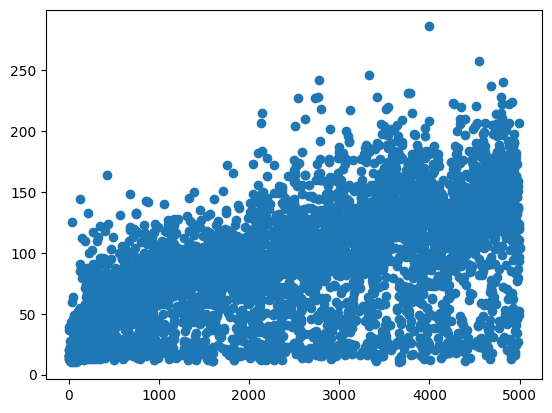

In [5]:
agent.Qtrain(5000)

In [6]:
agent.visualizing_Qcart()

Game terminated after 109 steps with reward 110.0


In [7]:
HTML('<img src="/Users/Soham/Documents/CMI-SEM 3/Advanced ML/RL_agent_Q.gif">')

#### SARSA Learning update

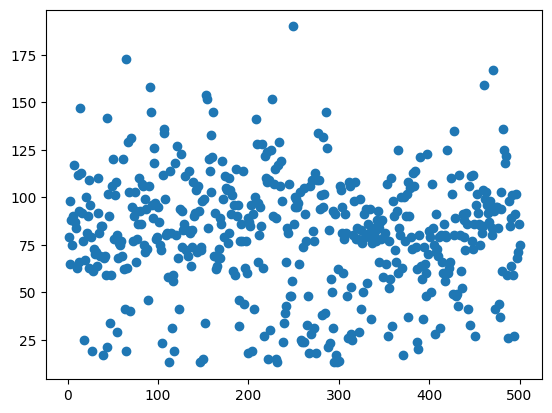

In [15]:
agent.SARSAlearning(500)

In [16]:
agent.visualizing_Sarsa_cart()

Game terminated after 105 steps with reward 106.0


In [17]:
HTML('<img src="/Users/Soham/Documents/CMI-SEM 3/Advanced ML/RL_agent_Sarsa.gif">')

Episode 1000 stopped in step : 106 with total reward : 170 in time 2.2172927856445312e-05
Episode 2000 stopped in step : 47 with total reward : 76 in time 2.002716064453125e-05
Episode 3000 stopped in step : 18 with total reward : 18 in time 2.002716064453125e-05
Episode 4000 stopped in step : 81 with total reward : 142 in time 1.8835067749023438e-05
Episode 5000 stopped in step : 16 with total reward : 16 in time 2.002716064453125e-05


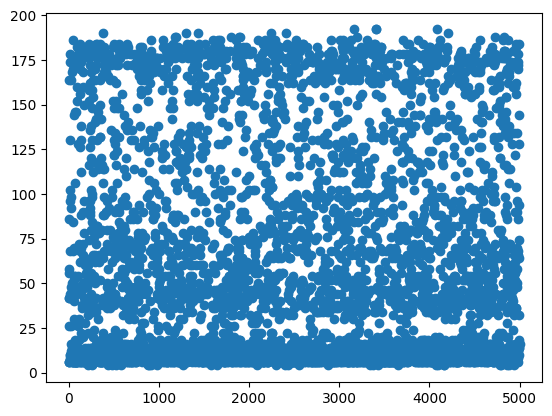

In [20]:
agent.Q_version_two(5000)

In [21]:
agent.visualizing_Q_v2_cart()

Game terminated after 92 steps with reward 176


In [22]:
HTML('<img src="/Users/Soham/Documents/CMI-SEM 3/Advanced ML/RL_agent_Q_v2.gif">')